This is early experimenting with importing real world data, playing around with our existing code, and determining how/if h5py (HDF5) file format will be appropriate for our needs.

In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ramannoodles import spectrafit

In [2]:
CO_data = pd.read_excel('../../Baseline Subtracted Data/CarbonMonoxide_Baseline_Calibration.xlsx',
                        header=None, names=('x', 'y'))
Me_data = pd.read_excel('../../Baseline Subtracted Data/Methane_Baseline_Calibration.xlsx',
                        header=None, names=('x', 'y'))
H_data = pd.read_excel('../../Baseline Subtracted Data/Hydrogen_Baseline_Calibration.xlsx',
                        header=None, names=('x', 'y'))
FA_data = pd.read_excel('../../FormicAcid_3percentconc_400C_5s_00000.xlsx',
                        header=None, names=('x', 'y'))

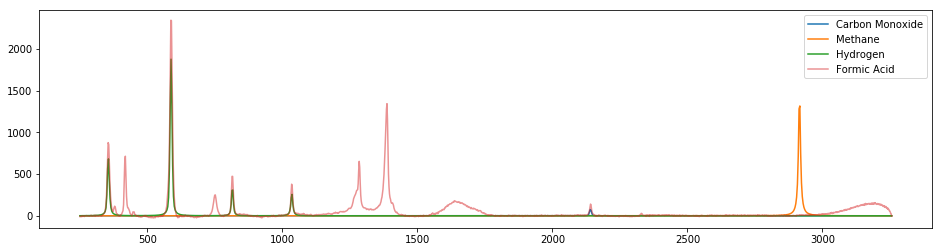

In [3]:
plt.figure(figsize=(16,4))
plt.plot(CO_data['x'], CO_data['y'], label='Carbon Monoxide')
plt.plot(Me_data['x'], Me_data['y'], label='Methane')
plt.plot(H_data['x'], H_data['y'], label='Hydrogen')
plt.plot(FA_data['x'], FA_data['y'], label='Formic Acid', alpha = 0.5)
plt.legend()

In [10]:
data = H_data

In [11]:
peaks, peak_list1 = spectrafit.peak_detect(data['x'].values, data['y'].values, height=10, prominence=20)
peaks

[(355.6504104104104, 682.2117661687759),
 (587.3333133133133, 1877.5935473330196),
 (816.0073473473473, 309.10228007461126),
 (1035.6547747747748, 256.8016351111647)]

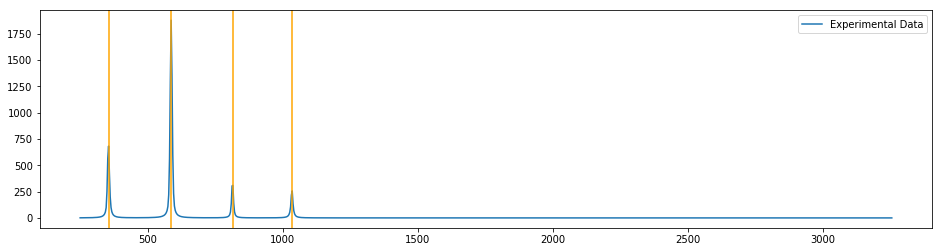

In [12]:
plt.figure(figsize=(16,4))
plt.plot(data['x'], data['y'], label='Experimental Data')
for i in peak_list1[0]:
    plt.axvline(x=data['x'][i], color='orange')
plt.legend()

In [13]:
mod, pars = spectrafit.set_params(peaks) 

In [14]:
out = spectrafit.model_fit(data['x'].values, data['y'].values, mod, pars)
print(out.fit_report())

[[Model]]
    (((Model(pvoigt, prefix='p1_') + Model(pvoigt, prefix='p2_')) + Model(pvoigt, prefix='p3_')) + Model(pvoigt, prefix='p4_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 739
    # data points      = 1000
    # variables        = 12
    chi-square         = 36094.1489
    reduced chi-square = 36.5325394
    Akaike info crit   = 3610.13077
    Bayesian info crit = 3669.02384
[[Variables]]
    p1_fraction:   0.68821684 +/- 0.02998040 (4.36%) (init = 0.5)
    p1_sigma:      4.53045639 +/- 0.05709472 (1.26%) (init = 50)
    p1_center:     355.6504 (fixed)
    p1_amplitude:  8518.11804 +/- 92.5906520 (1.09%) (init = 1)
    p1_fwhm:       9.06091278 +/- 0.11418945 (1.26%) == '2.0000000*p1_sigma'
    p1_height:     682.2118 (fixed)
    p2_fraction:   0.57368567 +/- 0.01186410 (2.07%) (init = 0.5)
    p2_sigma:      4.40829455 +/- 0.01933399 (0.44%) (init = 50)
    p2_center:     587.3333 (fixed)
    p2_amplitude:  21616.9396 +/- 91.4135279 (0.42%) (

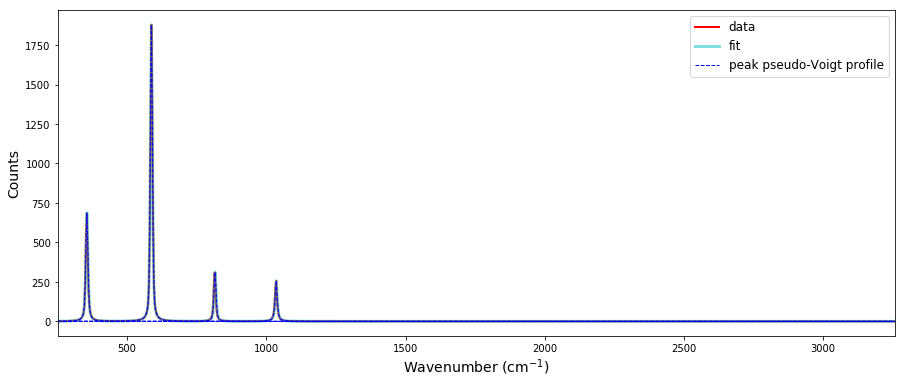

In [15]:
spectrafit.plot_fit(data['x'].values, data['y'].values, out, plot_components=True)

Using our existing code with the baselined single compound data the curve fitting appears to work well. Expecially when a Voigt or Pseudo-Voigt model is used opposed to the Lorentzian. Next we begin to experiment with h5py (HDF5 file format) for storing the data and the result of the curve fitting for future comparison with multi-compound spectra.

Ok. In order to impliment h5py and the HDF5 file system (which I believe we should) we need to make a new .py module to replace shoyu.py. In this markdown cell I will attempt to do exactly that. First I will outline the functions that will be needed:

## function brainstorm

#### def new_calibration(new_filename)  
    initialize an empty .hdp5 file with the input name
    
#### def add_compound(data_file, custom_label=None)
    # file must contain only two columns, the first containing wavenumber data and the second count data.
    # no headings
    check if the file is csv or xlsx and import data using the appropriate pandas function
    confirm that data is listed from smallest wavenumber to highest, correct if not
    fit the data using the pseudo-voigt model
    save the raw data and the fit results to the calibration .hdp5 using filename or custom_label

In [ ]:
from ramannoodles import dataprep

In [ ]:
# with the functions written we can now create a new calibration file (cal_file)
# this file can only be made once and compounds can be added to it later
cal_file = calibration.new_cal('cal_example')

In [ ]:
# first we add methane to the cal_file
cal_file = calibration.add_compound('cal_example.hdf5',
                                    'cal_example compounds/Methane_Baseline_Calibration.xlsx',
                                    label='Methane')                              

In [ ]:
# next we add hydrogen to the cal_file
cal_file = calibration.add_compound('cal_example.hdf5',
                                    'cal_example compounds/Hydrogen_Baseline_Calibration.xlsx',
                                    label='Hydrogen') 

In [ ]:
# last we add carbon monoxide to the cal_file
cal_file = calibration.add_compound('cal_example.hdf5',
                                    'cal_example compounds/CarbonMonoxide_Baseline_Calibration.xlsx',
                                    label='Carbon Monoxide') 

In [ ]:
# now we can list all the keys in cal_example.hdf5
list(cal_file.keys())

In [ ]:
# each key contains the x and y data as well as all the fit parameters for each detected peak
print(list(cal_file['Hydrogen'].keys()))
# each peak has parameters fraction, sigma, center, amplitude, fwhm, and height, in that order
print(list(cal_file['Hydrogen/Peak_1']))

As we update the peakidentify.py functions, we can read the cal_file in read only mode to ensure that we do not accidentally overwrite any of the data

one additional function for uploading data for a single compound at a variety of temperatures and residence times

In [ ]:
hdf5 = h5py.File('cal_example.hdf5', 'r')

In [ ]:
# this is the original development for a function that will display the contents of a h5py.File
# down at least three levels. Datasets are labeled 

def view_hdf5(filename):
    """docstring"""
    print('**** {} ****'.format(filename))
    hdf5 = h5py.File(filename, 'r')
    for _,layer_1 in enumerate(list(hdf5.keys())):
        if isinstance(hdf5[layer_1], h5py.Group):
            print('\033[1m{}\033[0m'.format(layer_1))
            for _,layer_2 in enumerate(list(hdf5[layer_1].keys())):
                if isinstance(hdf5['{}/{}'.format(layer_1, layer_2)], h5py.Group):
                    print('|    \033[1m{}\033[0m'.format(layer_2))
                    for _,layer_3 in enumerate(list(hdf5['{}/{}'.format(layer_1, layer_2)])):
                        if isinstance(hdf5['{}/{}/{}'.format(layer_1, layer_2, layer_3)], h5py.Group):
                            print('|    |    \033[1m{}\033[0m/...'.format(layer_3))
                        else:
                            print('|    |    {}'.format(layer_3))
                else:
                    print('|    {}'.format(layer_2))
        else:
            print('{}'.format(layer_1))
    
    

In [ ]:
# formic acid experimental data h5py test
FA = dataprep.new_hdf5('FA_exp_300')

In [ ]:
FA_300 = pd.read_csv('../../Baseline Subtracted Data/Formic Acid Data/300 C/FA_3.6wt__300C_25s.csv',
                        header=None, names=('x', 'y'))
FA_300.head()

In [ ]:
FA['300C/25s/x'] = FA_300['x']
FA['300C/25s/y'] = FA_300['y']

In [ ]:
# import data
data_filename = '../../Baseline Subtracted Data/Formic Acid Data/300 C/FA_3.6wt__300C_35s.csv'
hdf5_filename = 'FA_exp_300.hdf5'
FA_300_35 = pd.read_csv(data_filename, header=None, names=('x', 'y'))

# extract experimental parameters from filename
specs = data_filename.split('/')[-1].split('.')[:-1]
if len(specs) > 1:
    spec = ''
    for _,element in enumerate(specs):
        spec = str(spec+element)
    specs = spec
specs = specs.split('_')
specs
time = specs[-1]
temp = specs[-2]

In [ ]:
exp_filename = 'FA_exp_300.hdf5'
data_filename = '../../Baseline Subtracted Data/Formic Acid Data/300 C/FA_3.6wt__300C_55s.csv'


# function to add a dataset to experiment hdf5
def add_experiment(cal_filename, data_filename):
    """docstring"""
    # handling input errors
    if not isinstance(cal_filename, str):
        raise TypeError('Passed value of `cal_filename` is not a string! Instead, it is: '
                        + str(type(cal_filename)))
    if not isinstance(data_filename, str):
        raise TypeError('Passed value of `data_filename` is not a string! Instead, it is: '
                        + str(type(data_filename)))
    # r+ is read/write mode and will fail if the file does not exist
    exp_file = h5py.File(exp_filename, 'r+')
    if data_filename.split('.')[-1] == 'xlsx':
        data = pd.read_excel(data_filename, header=None, names=('x', 'y'))
    elif data_filename.split('.')[-1] == 'csv':
        data = pd.read_csv(data_filename, header=None, names=('x', 'y'))
    else:
        print('data file type not recognized')
    # ensure that the data is listed from smallest wavenumber first
    if data['x'][:1].values > data['x'][-1:].values:
        data = data.iloc[::-1]
        data.reset_index(inplace=True, drop=True)
    else:
        pass
    # peak detection and data fitting
    fit_result = spectrafit.fit_data(data['x'].values, data['y'].values)
    # extract experimental parameters from filename
    specs = data_filename.split('/')[-1].split('.')[:-1]
    if len(specs) > 1:
        spec = ''
        for _,element in enumerate(specs):
            spec = str(spec+element)
        specs = spec
    specs = specs.split('_')
    specs
    time = specs[-1]
    temp = specs[-2]
    # write data to .hdf5
    exp_file['{}/{}/wavenumber'.format(temp, time)] = data['x']
    exp_file['{}/{}/counts'.format(temp, time)] = data['y']
    for i, _ in enumerate(fit_result):
        if i < 9:
            exp_file['{}/{}/Peak_0{}'.format(temp, time, i+1)] = fit_result[i]
        else:
            exp_file['{}/{}/Peak_{}'.format(temp, time, i+1)] = fit_result[i]
    exp_file.close()

In [ ]:
add_experiment('FA_exp_300.hdf5', '../../Baseline Subtracted Data/Formic Acid Data/300 C/FA_3.6wt__300C_65s.csv')

In [ ]:
view_hdf5('FA_exp_300.hdf5')

In [ ]:
import os

In [ ]:
os.listdir('../../Baseline Subtracted Data/Formic Acid Data/300 C')

In [ ]:
from ramannoodles import dataprep
dataprep.new_hdf5('exp_test')
dataprep.add_experiment('exp_test.hdf5', '../../Baseline Subtracted Data/Formic Acid Data/300 C/FA_3.6wt__300C_25s.csv')
exp_file = h5py.File('exp_test.hdf5', 'r')

In [ ]:
view_hdf5('exp_test.hdf5')

In [ ]:
len(exp_file['300C/25s']) == 18

In [ ]:
assert len(exp_file) == 1, 'incorrect number of 1st order groups'
assert list(exp_file.keys())[0] == '300C', '1st order group name incorrect'
assert len(exp_file['300C']) ==1, 'incorrect number of 2nd order groups'
assert list(exp_file['300C'].keys())[0] == '25s', '2nd order group name incorrect'
assert '300C/25s/wavenumber' in exp_file, 'x data (wavenumber) not stored correctly'
assert '300C/25s/counts' in exp_file, 'y data (counts) not stored correctly'
assert len(exp_file['300C/25s']) == 18, 'incorrect number of peaks + raw_data stored'

In [ ]:
try:
    dataprep.add_experiment(4.2, 'ramannoodles/tests/test_files/CarbonMonoxide_Baseline_Calibration.xlsx')
except TypeError:
    print('A float was passed to the function, and it was handled well with a TypeError.')
try:
    dataprep.add_experiment('test.hdp5', 4.2)
except TypeError:
    print('A float was passed to the function, and it was handled well with a TypeError.')
try:
    dataprep.add_experiment('test.txt', 'ramannoodles/tests/test_files/CarbonMonoxide_Baseline_Calibration')
except TypeError:
    print('A .txt file was passed to the function, and it was handled will with a TypeError.')